In [99]:
# Load dataset
import pandas as pd
data = pd.read_csv(r"C:\Users\navya\Downloads\2019.csv")
data.head()

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,1,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393
1,2,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410
2,3,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341
3,4,Iceland,7.494,1.380,1.624,1.026,0.591,0.354,0.118
4,5,Netherlands,7.488,1.396,1.522,0.999,0.557,0.322,0.298


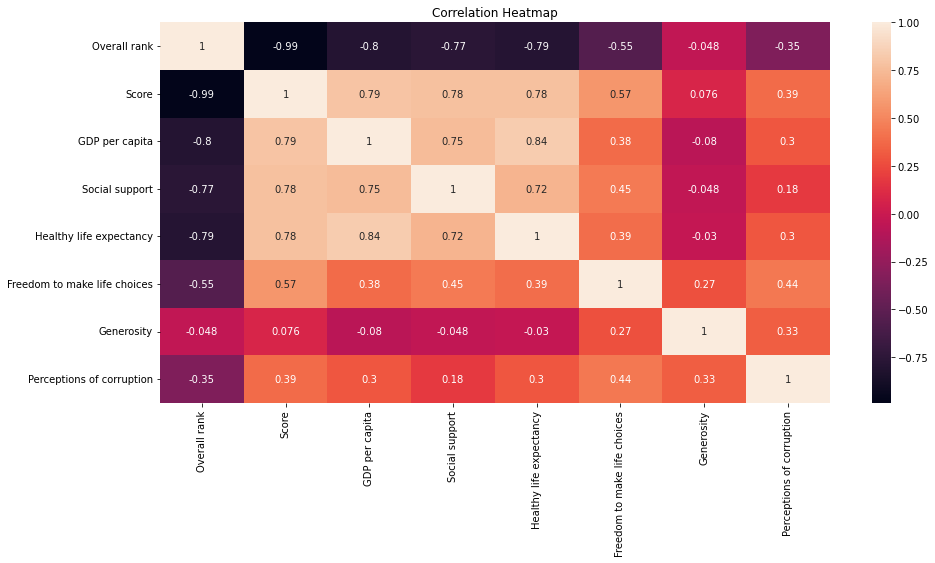

In [100]:
data_num = data.select_dtypes(include=['int64', 'float64'])
Correlation_matrix = data_num.corr()
plt.figure(figsize=(15, 7))
sns.heatmap(Correlation_matrix, annot=True)
plt.title('Correlation Heatmap')
plt.show()

## Data preprocessing

In [101]:
data.isnull().sum().sum()

0

In [102]:
features = ["GDP per capita", "Social support", "Healthy life expectancy","Freedom to make life choices"]
target = "Score"

X = data[features]
y = data[target]

In [103]:
# Check Multicollinearity
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

print("VIF before handling multicollinearity:")
print(calculate_vif(X))

VIF before handling multicollinearity:
                        Feature        VIF
0                GDP per capita  21.331929
1                Social support  28.631984
2       Healthy life expectancy  33.662937
3  Freedom to make life choices  10.280102


In [104]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=41)

In [105]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

## Model selection

In [106]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_sc, y_train)
ridge_preds = ridge.predict(X_test_sc)

In [107]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

In [108]:
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)

## Model Evaluation

In [109]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def evaluate_model(name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{name} Performance:")
    print(f"R² Score: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}\n")


In [110]:
# Evaluate models
evaluate_model("Ridge Regression", y_test, ridge_preds)
evaluate_model("Random Forest", y_test, rf_preds)
evaluate_model("XGBoost", y_test, xgb_preds)

Ridge Regression Performance:
R² Score: 0.8756
RMSE: 0.4201
MAE: 0.3299

Random Forest Performance:
R² Score: 0.7968
RMSE: 0.5368
MAE: 0.4297

XGBoost Performance:
R² Score: 0.8078
RMSE: 0.5221
MAE: 0.4312



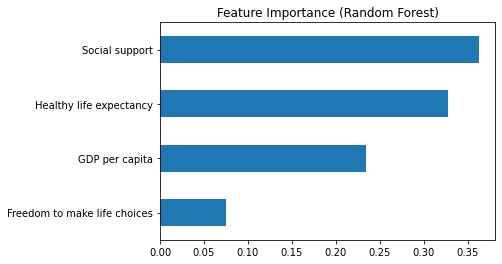

In [111]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
feature_importances.sort_values().plot(kind="barh", title="Feature Importance (Random Forest)")
plt.show()

## Improve Model Performance

In [112]:
# Ridge Regression Hyperparameter Tuning
from sklearn.linear_model import RidgeCV

# Define range of alpha values
alphas = np.logspace(-3, 3, 100)  # From 0.001 to 1000

# Cross-validation Ridge Regression
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv.fit(X_train_sc, y_train)

# Best alpha value
best_alpha = ridge_cv.alpha_
print(f"Best Alpha for Ridge Regression: {best_alpha}")

# Train Ridge with best alpha
ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(X_train_sc, y_train)
ridge_best_preds = ridge_best.predict(X_test_sc)

# Evaluate again
evaluate_model("Tuned Ridge Regression", y_test, ridge_best_preds)


Best Alpha for Ridge Regression: 17.47528400007683
Tuned Ridge Regression Performance:
R² Score: 0.8719
RMSE: 0.4261
MAE: 0.3382



In [113]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid for Random Forest
rf_params = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

rf_tuner = RandomizedSearchCV(RandomForestRegressor(random_state=42), rf_params, n_iter=10, cv=5, n_jobs=-1, random_state=42)
rf_tuner.fit(X_train, y_train)

# Best Random Forest model
rf_best = rf_tuner.best_estimator_
rf_best_preds = rf_best.predict(X_test)

# Evaluate again
evaluate_model("Tuned Random Forest", y_test, rf_best_preds)



Tuned Random Forest Performance:
R² Score: 0.7956
RMSE: 0.5384
MAE: 0.4365



In [114]:
# Hyperparameter grid for XGBoost
xgb_params = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7],
    "subsample": [0.8, 1.0]
}

xgb_tuner = RandomizedSearchCV(XGBRegressor(random_state=42), xgb_params, n_iter=10, cv=5, n_jobs=-1, random_state=42)
xgb_tuner.fit(X_train, y_train)

# Best XGBoost model
xgb_best = xgb_tuner.best_estimator_
xgb_best_preds = xgb_best.predict(X_test)

# Evaluate again
evaluate_model("Tuned XGBoost", y_test, xgb_best_preds)

Tuned XGBoost Performance:
R² Score: 0.8186
RMSE: 0.5071
MAE: 0.3893



## **Final Insights**  



- The dataset exhibited **high multicollinearity** among `GDP per capita`, `Social Support`, and `Healthy Life Expectancy`, with **VIF > 10**, indicating strong correlations. This made **Ridge Regression** the most suitable choice for handling multicollinearity effectively.  

- **Best Performing Model: Ridge Regression**  
  - **Optimal α (Regularization Strength):** 17.48  
  - **Final Performance Metrics:**  
    - **R² Score:** 0.8719 → Explains 87.19% of the variance in happiness scores.  
    - **RMSE:** 0.4261 → Lower error compared to other models.  
    - **MAE:** 0.3382 → Best at minimizing absolute errors.  

- Despite **hyperparameter tuning**, both **Random Forest (R² = 0.7956)** and **XGBoost (R² = 0.8186)** underperformed compared to Ridge Regression, reinforcing that a regularized linear model was the best choice for this dataset.